In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from unidecode import unidecode
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
import locale
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import shap

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_3_dummy.csv.gz")
df.head()

,valor_arancel,desertor_1,prom_notas_media,fscu,gratuidad,beca,dif_ing_ult_mat,edad,misma_region,gen_alu_mujer,...,area_conocimiento_tecnologia,acreditada_carr_no_acreditada,acreditada_inst_no_acreditada,tipo_ensenanza_colegio_otro,tipo_ensenanza_colegio_tp_comercial,tipo_ensenanza_colegio_tp_industrial,tipo_ensenanza_colegio_tp_tecnica,dependencia_colegio_otro,dependencia_colegio_particular_pagado,dependencia_colegio_particular_subvencionado
0,1390000.0,1,6.4,0,0,0,0,35,1,1,...,0,1,0,0,0,0,0,0,0,1
1,1850000.0,1,5.5,0,0,1,0,31,1,0,...,1,0,0,0,0,0,0,0,0,1
2,803000.0,0,4.7,0,0,0,0,29,1,0,...,1,1,1,0,0,0,0,0,0,1
3,1690000.0,0,6.0,0,0,0,0,29,1,0,...,1,1,0,0,0,0,0,0,0,0
4,1480000.0,0,6.4,0,0,0,0,16,1,1,...,0,1,0,0,0,0,0,0,0,1


In [3]:
df.shape

(885586, 44)

In [4]:
df["desertor_1"].value_counts("%"), df["desertor_1"].value_counts()

(0    0.759665
 1    0.240335
 Name: desertor_1, dtype: float64,
 0    672749
 1    212837
 Name: desertor_1, dtype: int64)

# Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["desertor_1"]), df["desertor_1"], random_state=42, test_size=0.10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((797027, 43), (88559, 43), (797027,), (88559,))

In [6]:
pd.Series(y_train).value_counts("%") * 100

0    75.978731
1    24.021269
Name: desertor_1, dtype: float64

# Undersampling

In [7]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled.shape

(382912, 43)

In [8]:
pd.Series(y_resampled).value_counts() 

0    191456
1    191456
Name: desertor_1, dtype: int64

In [9]:
frecuencias = pd.concat([
    X_train.loc[:, "misma_region": "dependencia_colegio_particular_subvencionado"].sum() / X_train.shape[0] * 100,
    X_resampled.loc[:, "misma_region": "dependencia_colegio_particular_subvencionado"].sum() / X_resampled.shape[0] * 100,
], axis=1)
frecuencias[np.abs(frecuencias[0] - frecuencias[1]) > 0.5]

,0,1
gen_alu_mujer,49.971456,47.310087
tipo_inst_1_institutos_profesionales,68.072725,67.009391
area_conocimiento_salud,13.749346,12.975305
area_conocimiento_tecnologia,33.624206,34.899925
acreditada_carr_no_acreditada,45.540992,46.721179
acreditada_inst_no_acreditada,10.143571,11.582035
tipo_ensenanza_colegio_tp_comercial,16.247881,15.640669
dependencia_colegio_particular_subvencionado,50.150371,49.342408


# Modelos

## Regresión Logística

In [10]:
rl = LogisticRegressionCV(cv=10, random_state=42, n_jobs=-1).fit(X_resampled, y_resampled)

In [11]:
print(classification_report(y_test, rl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     67178
           1       0.28      0.55      0.37     21381

    accuracy                           0.56     88559
   macro avg       0.54      0.55      0.52     88559
weighted avg       0.67      0.56      0.59     88559



In [12]:
cr = pd.DataFrame(
    classification_report(y_test, rl.predict(X_test), output_dict=True)
).T.rename(columns={"support": "# Real"})
cr['# Real'] = cr["# Real"].astype(int)
cr["# Predicciones"] = [47242, 41317, 0, 88559, 88559]
cr.index = ["No desertores", "Desertores", "Accuracy", "Macro avg.", "Weighted avg."]
cr.round(2)

,precision,recall,f1-score,# Real,# Predicciones
No desertores,0.80,0.56,0.66,67178,47242
Desertores,0.28,0.55,0.37,21381,41317
Accuracy,0.56,0.56,0.56,0,0
Macro avg.,0.54,0.55,0.52,88559,88559
Weighted avg.,0.67,0.56,0.59,88559,88559


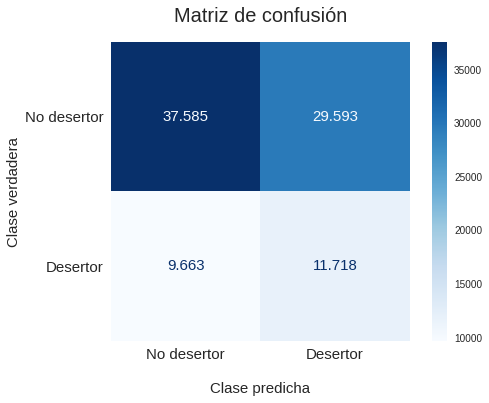

In [13]:
predictions = rl.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rl.classes_)
disp.plot(cmap="Blues", values_format='');
for labels in disp.text_.ravel():
    t = labels.get_text()
    labels.set_text(locale.format_string('%.0f', int(t), grouping=True, monetary=True))
    labels.set_fontsize(15)
plt.grid(False);
plt.title("Matriz de confusión", fontsize=20, pad=20);
plt.ylabel("Clase verdadera", fontsize=15);
plt.xlabel("Clase predicha", fontsize=15, labelpad=20);
plt.yticks([0, 1], ["No desertor", "Desertor"], fontsize=15);
plt.xticks([0, 1], ["No desertor", "Desertor"], fontsize=15);

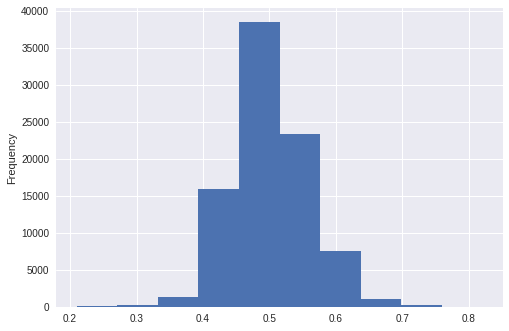

In [14]:
pd.Series(rl.predict_proba(X_test)[:, 1]).plot(kind="hist");

In [15]:
con_proba = df.copy()
con_proba["proba"] = rl.predict_proba(df.drop(columns=["desertor_1"]))[:, 1]

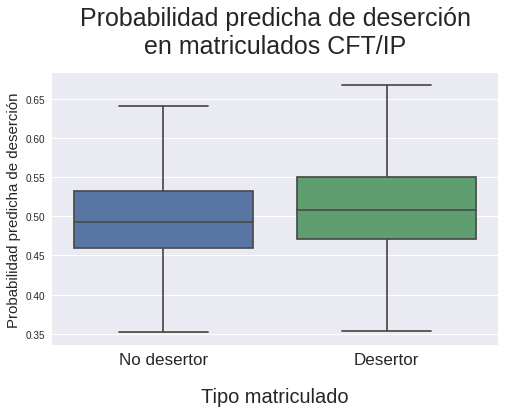

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=con_proba, y="proba", x="desertor_1", showfliers=False);
plt.xticks([0,1], ["No desertor", "Desertor"], fontsize=17);
plt.xlabel("Tipo matriculado", fontsize=20, labelpad=20);
plt.ylabel("Probabilidad predicha de deserción", fontsize=15);
plt.title("Probabilidad predicha de deserción\nen matriculados CFT/IP", fontsize=25, pad=20);

In [17]:
atributos = df.drop(columns=["desertor_1"]).columns
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
logit_1 = smf.logit(f"desertor_1 ~ {' + '.join(atributos)}", data=df_resampled).fit()
coefs = logit_1.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.637797
         Iterations 5


In [18]:
coefs[(coefs["P>|z|"] < 0.05) & (coefs["Coef."] > 0)].sort_values(by=["Coef."], ascending=False)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,3.278874,0.056518,58.014215,0.000000e+00,3.168100,3.389648
area_conocimiento_arte_y_arquitectura,0.319356,0.016682,19.143484,1.096843e-81,0.286660,0.352053
region_sede_los_lagos,0.305977,0.025408,12.042398,2.126814e-33,0.256177,0.355776
acreditada_inst_no_acreditada,0.300911,0.012849,23.418614,2.761908e-121,0.275727,0.326095
region_sede_magallanes,0.273407,0.044522,6.140889,8.206103e-10,0.186145,0.360670
tipo_ensenanza_colegio_otro,0.269981,0.024066,11.218228,3.318538e-29,0.222812,0.317150
region_sede_arica_y_parinacota,0.255230,0.036064,7.077166,1.471321e-12,0.184546,0.325914
region_sede_los_rios,0.250348,0.034043,7.353833,1.926017e-13,0.183625,0.317072
region_sede_lib_gral_b_ohiggins,0.243446,0.025416,9.578594,9.837541e-22,0.193632,0.293260
region_sede_nuble,0.238722,0.030882,7.730000,1.075464e-14,0.178193,0.299250


In [19]:
coefs[(coefs["P>|z|"] < 0.05) & (coefs["Coef."] < 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
valor_arancel,-3.350837e-08,1.053053e-08,-3.182020,1.462518e-03,-5.414783e-08,-1.286890e-08
prom_notas_media,-6.347434e-01,8.820819e-03,-71.959693,0.000000e+00,-6.520319e-01,-6.174549e-01
gratuidad,-5.084477e-01,1.018575e-02,-49.917550,0.000000e+00,-5.284114e-01,-4.884840e-01
beca,-4.283722e-01,8.736973e-03,-49.029811,0.000000e+00,-4.454963e-01,-4.112480e-01
dif_ing_ult_mat,-4.242569e-01,3.549941e-03,-119.510983,0.000000e+00,-4.312147e-01,-4.172992e-01
gen_alu_mujer,-3.001774e-01,8.372773e-03,-35.851608,1.735963e-281,-3.165877e-01,-2.837670e-01
tipo_inst_1_institutos_profesionales,-1.588912e-01,7.750980e-03,-20.499496,2.175357e-93,-1.740828e-01,-1.436995e-01
area_conocimiento_ciencias_sociales,-1.852793e-01,1.678021e-02,-11.041537,2.408771e-28,-2.181679e-01,-1.523907e-01
area_conocimiento_educacion,-7.732841e-02,1.285156e-02,-6.017043,1.776319e-09,-1.025170e-01,-5.213981e-02
area_conocimiento_salud,-6.383634e-02,1.211349e-02,-5.269856,1.365309e-07,-8.757834e-02,-4.009434e-02


## DT

In [20]:
dt = DecisionTreeClassifier(random_state=42).fit(X_resampled, y_resampled)
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72     67178
           1       0.35      0.62      0.45     21381

    accuracy                           0.63     88559
   macro avg       0.60      0.63      0.58     88559
weighted avg       0.72      0.63      0.66     88559



In [21]:
def plot_importance(fit_model, feat_names, n=10):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1][:n]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(n), list(reversed(tmp_importance[sort_importance])))
    plt.yticks(range(n), list(reversed(names)), rotation=0)
    return names

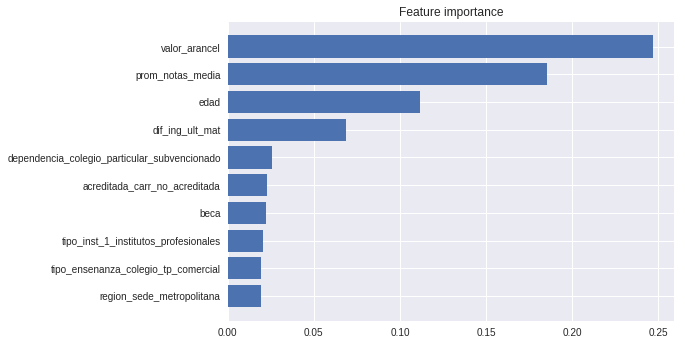

In [22]:
_ = plot_importance(dt, df.drop(columns=["desertor_1"]).columns, n=10)

## XGBoost

In [23]:
clf_pipe = Pipeline(
    steps=[
        ("selection", SelectPercentile(f_classif)),
        ("clf", XGBClassifier(random_state=42))
    ]
)

clf_pipe

Pipeline(steps=[('selection', SelectPercentile()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [24]:
param_grid = {
    "selection__percentile": [80, 95],
    "clf__gamma": [0.001, 0.1, 2]
}

In [25]:
search = GridSearchCV(
    clf_pipe, param_grid, n_jobs=-1, scoring="f1_macro", cv=2
).fit(X_resampled, y_resampled)

In [26]:
search.best_params_

{'clf__gamma': 0.001, 'selection__percentile': 80}

In [27]:
x_features = search.best_estimator_[0].fit_transform(X_resampled, y_resampled)
columns = np.asarray(X_resampled.columns.values)
support = np.asarray(search.best_estimator_[0].get_support())
columns_with_support = columns[support]
columns_with_support

array(['valor_arancel', 'prom_notas_media', 'fscu', 'gratuidad', 'beca',
       'dif_ing_ult_mat', 'edad', 'misma_region', 'gen_alu_mujer',
       'tipo_inst_1_institutos_profesionales', 'region_sede_atacama',
       'region_sede_biobio', 'region_sede_los_lagos',
       'region_sede_los_rios', 'region_sede_magallanes',
       'region_sede_maule', 'region_sede_metropolitana',
       'region_sede_valparaiso', 'region_sede_nuble',
       'area_conocimiento_arte_y_arquitectura',
       'area_conocimiento_ciencias_basicas',
       'area_conocimiento_ciencias_sociales',
       'area_conocimiento_educacion', 'area_conocimiento_salud',
       'area_conocimiento_tecnologia', 'acreditada_carr_no_acreditada',
       'acreditada_inst_no_acreditada', 'tipo_ensenanza_colegio_otro',
       'tipo_ensenanza_colegio_tp_comercial',
       'tipo_ensenanza_colegio_tp_industrial',
       'tipo_ensenanza_colegio_tp_tecnica', 'dependencia_colegio_otro',
       'dependencia_colegio_particular_pagado',
       '

In [28]:
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.66      0.76     67178
           1       0.40      0.72      0.52     21381

    accuracy                           0.68     88559
   macro avg       0.64      0.69      0.64     88559
weighted avg       0.77      0.68      0.70     88559



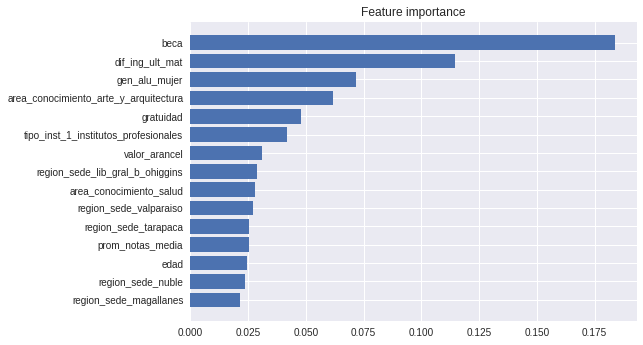

In [29]:
_ = plot_importance(search.best_estimator_[1], df.drop(columns=["desertor_1"]).columns, n=15)

In [30]:
def class_feature_importance(X, Y, feature_importances, n_feats=10):
    sort_importance = np.argsort(feature_importances)[::-1][:n_feats]
    feat_names = X.columns
    names = [feat_names[i] for i in sort_importance]
    importancias = feature_importances[sort_importance]
    N, M = X[names].shape
    X = scale(X[names])

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*importancias)
        )

    #return out, names
    t = pd.DataFrame(out)
    t["atributo"] = names
    t["abs"] = t[0].abs()
    return t.sort_values(by=["abs"])

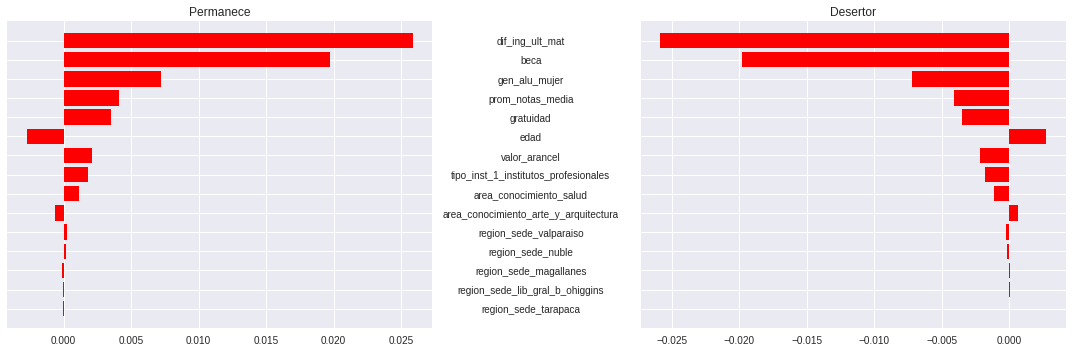

In [31]:
result = class_feature_importance(
    X_resampled, y_resampled, search.best_estimator_[1].feature_importances_, 15
)

titles = ["Permanece", "Desertor"]
plt.figure(figsize=(15, 5))
for t, i in zip(titles, range(len(set(y_resampled)))):
    ax = plt.subplot(1, 2, i+1)
    plt.title(t)
    plt.barh(
        range(len(result[i])),
        result[i],
        color="r",
        align="center"
    )
    plt.yticks(
        range(len(result[i])),
        result["atributo"] if i == 1 else [""] * result.shape[0],
        rotation=0,
        ha="center"
    )
    ax.tick_params(axis='y', which='major', pad=110)
    plt.ylim([-1, len(result[i])])
    
plt.tight_layout()

### Shap values

https://github.com/slundberg/shap

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [43]:
explainer = shap.TreeExplainer(search.best_estimator_['clf'])
observations = search.best_estimator_['selection'].transform(X_train)

In [ ]:
shap_e = explainer(observations)

In [44]:
shap_values = explainer.shap_values(observations)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


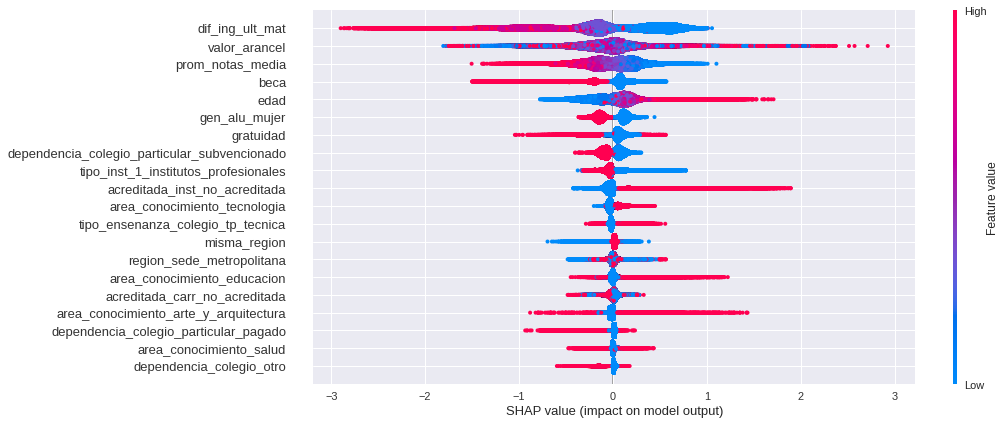

In [45]:
shap.summary_plot(shap_values, observations, class_names=search.best_estimator_['clf'].classes_, feature_names=columns_with_support, plot_size=[15, 6])

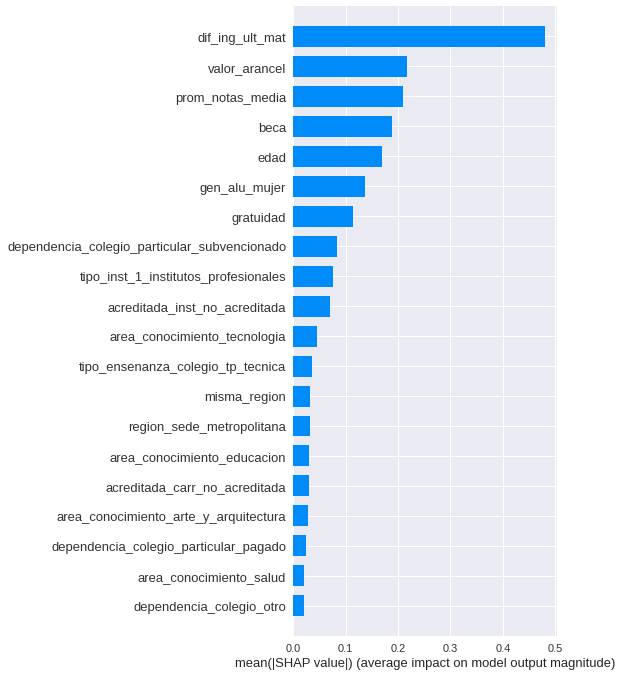

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [46]:
shap.summary_plot(shap_values, observations, plot_type="bar", class_names=search.best_estimator_['clf'].classes_, feature_names=columns_with_support)

In [38]:
shap.plots.bar(shap_values)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [36]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [37]:
print_feature_importances_shap_values(shap_values, X_test.columns)

dif_ing_ult_mat -> 0.4807 (softmax = 0.0444)
valor_arancel -> 0.2170 (softmax = 0.0341)
prom_notas_media -> 0.2090 (softmax = 0.0339)
beca -> 0.1899 (softmax = 0.0332)
edad -> 0.1680 (softmax = 0.0325)
gen_alu_mujer -> 0.1358 (softmax = 0.0315)
gratuidad -> 0.1133 (softmax = 0.0308)
area_conocimiento_tecnologia -> 0.0837 (softmax = 0.0299)
tipo_inst_1_institutos_profesionales -> 0.0768 (softmax = 0.0297)
area_conocimiento_arte_y_arquitectura -> 0.0710 (softmax = 0.0295)
region_sede_nuble -> 0.0452 (softmax = 0.0287)
area_conocimiento_educacion -> 0.0354 (softmax = 0.0285)
misma_region -> 0.0323 (softmax = 0.0284)
region_sede_lib_gral_b_ohiggins -> 0.0316 (softmax = 0.0284)
region_sede_tarapaca -> 0.0297 (softmax = 0.0283)
area_conocimiento_agropecuaria -> 0.0297 (softmax = 0.0283)
region_sede_magallanes -> 0.0290 (softmax = 0.0283)
area_conocimiento_salud -> 0.0249 (softmax = 0.0282)
region_sede_valparaiso -> 0.0205 (softmax = 0.0280)
area_conocimiento_humanidades -> 0.0199 (softmax = 

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [ ]:
shap.summary_plot(shap_values)

## Dummy

In [ ]:
aleatorio = DummyClassifier(strategy="stratified", random_state=42).fit(X_resampled, y_resampled)
print(classification_report(y_test, aleatorio.predict(X_test)))